In [3]:
"""
Demand-Supply Analysis Script

This script analyzes the relationship between energy demand and renewable energy supply (RES) generation,
including price trends, coverage percentages, and surplus/deficit calculations.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 6)

# Define paths
BASE_DIR = Path().resolve().parent
DATA_DIR = BASE_DIR / 'data/final/Italy'
OUTPUT_DIR = BASE_DIR / 'outputs'
IMAGES_DIR = OUTPUT_DIR / 'images'

In [4]:
# Create output directories
for directory in [OUTPUT_DIR, IMAGES_DIR]:
    os.makedirs(directory, exist_ok=True)

In [5]:


def load_data():
    """
    Load the forecasted data files for price, demand, and RES generation.
    
    Returns:
        tuple: (price_df, demand_df, res_df) - DataFrames containing the loaded data
    """
    print("Loading forecasted data files...")
    
    try:
        # Load price data
        price_file = DATA_DIR / 'energy_price2025_2029.csv'
        price_df = pd.read_csv(price_file)
        print(f"Successfully loaded price data: {len(price_df)} rows")
        
        # Load demand data - check both possible locations
        try:
            demand_file = DATA_DIR / 'energy_demand2025_2029.csv'
            demand_df = pd.read_csv(demand_file)
        except FileNotFoundError:
            demand_file = OUTPUT_DIR / 'energy_demand2025_2029.csv'
            demand_df = pd.read_csv(demand_file)
        print(f"Successfully loaded demand data: {len(demand_df)} rows")
        
        # Load RES generation data
        res_file = DATA_DIR / 'energy_res2025_2029.csv'
        res_df = pd.read_csv(res_file)
        print(f"Successfully loaded RES generation data: {len(res_df)} rows")
        
        return price_df, demand_df, res_df
    
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return None, None, None






In [6]:
def preprocess_data(price_df, demand_df, res_df):
    """
    Preprocess and merge the data frames.
    
    Args:
        price_df: DataFrame with price data
        demand_df: DataFrame with demand data
        res_df: DataFrame with RES generation data
        
    Returns:
        DataFrame: Merged dataframe with all data
    """
    print("Preprocessing and merging data...")
    
    if price_df is None or demand_df is None or res_df is None:
        print("Cannot proceed with preprocessing due to missing data.")
        return None
    
    # Print column names for debugging
    print("Price data columns:", price_df.columns.tolist())
    print("Demand data columns:", demand_df.columns.tolist())
    print("RES data columns:", res_df.columns.tolist())
    
    # Handle specific column names for our data
    # For price data
    if 'price_eur_mwh' in price_df.columns:
        price_col = 'price_eur_mwh'
    else:
        # Find any column with 'price' in the name
        price_cols = [col for col in price_df.columns if 'price' in col.lower()]
        price_col = price_cols[0] if price_cols else None
    
    # For demand data
    if 'Demand' in demand_df.columns:
        demand_col = 'Demand'
    else:
        # Find any column with 'demand' in the name
        demand_cols = [col for col in demand_df.columns if 'demand' in col.lower()]
        demand_col = demand_cols[0] if demand_cols else None
    
    # For RES data
    if 'total_res_mw' in res_df.columns:
        res_col = 'total_res_mw'
    else:
        # Find any column with 'res' or 'generation' in the name
        res_cols = [col for col in res_df.columns if 'res' in col.lower() or 'generation' in col.lower()]
        res_col = res_cols[0] if res_cols else None
    
    # Check if all required columns were found
    if not all([price_col, demand_col, res_col]):
        print("Could not identify all required columns:")
        if not price_col:
            print("Price column not found")
        if not demand_col:
            print("Demand column not found")
        if not res_col:
            print("RES generation column not found")
        return None
    
    print(f"Using columns: Price='{price_col}', Demand='{demand_col}', RES='{res_col}'")
    
    # Convert date columns to datetime
    if 'Date' in price_df.columns:
        price_df['Date'] = pd.to_datetime(price_df['Date'])
    else:
        # Try to find a date column
        for col in price_df.columns:
            if price_df[col].dtype == 'object' and pd.to_datetime(price_df[col], errors='coerce').notna().all():
                price_df['Date'] = pd.to_datetime(price_df[col])
                break
    
    if 'Date' in demand_df.columns:
        demand_df['Date'] = pd.to_datetime(demand_df['Date'])
    else:
        # Try to find a date column
        for col in demand_df.columns:
            if demand_df[col].dtype == 'object' and pd.to_datetime(demand_df[col], errors='coerce').notna().all():
                demand_df['Date'] = pd.to_datetime(demand_df[col])
                break
    
    # For RES data, we need to create a Date column from year, month, day if it doesn't exist
    if 'Date' not in res_df.columns:
        if all(col in res_df.columns for col in ['year', 'month']):
            # Try to create a date from year and month (assuming day=1)
            res_df['Date'] = pd.to_datetime(res_df['year'].astype(str) + '-' + res_df['month'].astype(str) + '-01')
            
            # If day_of_year exists, we can create more precise dates
            if 'day_of_year' in res_df.columns:
                # Create dates using year and day of year
                res_df['Date'] = res_df.apply(
                    lambda row: pd.Timestamp(year=int(row['year']), month=1, day=1) + pd.Timedelta(days=int(row['day_of_year'])-1), 
                    axis=1
                )
    else:
        res_df['Date'] = pd.to_datetime(res_df['Date'])
    
    # Check if Date columns were successfully created
    if 'Date' not in price_df.columns or 'Date' not in demand_df.columns or 'Date' not in res_df.columns:
        print("Could not create Date columns for all dataframes")
        return None
    
    # Create copies with only the needed columns
    price_df_clean = price_df[['Date', price_col]].copy()
    demand_df_clean = demand_df[['Date', demand_col]].copy()
    res_df_clean = res_df[['Date', res_col]].copy()
    
    # Rename columns for consistency with the requested naming
    price_df_clean = price_df_clean.rename(columns={price_col: 'price_eur_mwh'})
    demand_df_clean = demand_df_clean.rename(columns={demand_col: 'demand_mw'})
    res_df_clean = res_df_clean.rename(columns={res_col: 'res_generation_mw'})
    
    # Merge dataframes
    merged_df = pd.merge(price_df_clean, demand_df_clean, on='Date', how='inner')
    merged_df = pd.merge(merged_df, res_df_clean, on='Date', how='inner')
    
    print(f"Successfully merged data: {len(merged_df)} rows")
    print(f"Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
    
    # Save merged data to CSV
    output_path = DATA_DIR / "price_demand_generation_prediction.csv"
    merged_df.to_csv(output_path, index=False)
    print(f"Saved merged data to: {output_path}")
    
    return merged_df

def calculate_monthly_aggregations(merged_df):
    """
    Calculate monthly aggregated variables.
    
    Args:
        merged_df: DataFrame with merged data
        
    Returns:
        DataFrame: Monthly aggregated data
    """
    print("Calculating monthly aggregations...")
    
    # Extract year and month
    monthly_df = merged_df.copy()
    monthly_df['Year'] = monthly_df['Date'].dt.year
    monthly_df['Month'] = monthly_df['Date'].dt.month
    monthly_df['YearMonth'] = monthly_df['Date'].dt.to_period('M')
    
    # Group by year and month
    monthly_agg = monthly_df.groupby(['Year', 'Month']).agg({
        'price_eur_mwh': 'mean',
        'demand_mw': lambda x: (x.mean() * 24 * 30),  # Approximate MWh per month (daily avg * 24h * 30 days)
        'res_generation_mw': lambda x: (x.mean() * 24 * 30)  # Approximate MWh per month
    }).reset_index()
    
    # Rename columns to reflect unit change from MW to MWh after calculation
    monthly_agg = monthly_agg.rename(columns={
        'demand_mw': 'demand_mwh',
        'res_generation_mw': 'res_generation_mwh'
    })
    
    # Calculate percentage of demand covered by RES and surplus/deficit
    monthly_agg['Pct_Demand_Covered'] = (monthly_agg['res_generation_mwh'] / monthly_agg['demand_mwh']) * 100
    monthly_agg['Surplus_Deficit'] = monthly_agg['res_generation_mwh'] - monthly_agg['demand_mwh']
    
    # Create YearMonth string for plotting
    monthly_agg['YearMonth_Str'] = monthly_agg['Year'].astype(str) + '-' + monthly_agg['Month'].astype(str).str.zfill(2)
    
    print(f"Generated monthly aggregations: {len(monthly_agg)} rows")
    
    return monthly_agg

def calculate_yearly_aggregations(merged_df):
    """
    Calculate yearly aggregated variables.
    
    Args:
        merged_df: DataFrame with merged data
        
    Returns:
        DataFrame: Yearly aggregated data
    """
    print("Calculating yearly aggregations...")
    
    # Extract year
    yearly_df = merged_df.copy()
    yearly_df['Year'] = yearly_df['Date'].dt.year
    
    # Group by year
    yearly_agg = yearly_df.groupby('Year').agg({
        'price_eur_mwh': 'mean',
        'demand_mw': lambda x: (x.mean() * 24 * 365),  # Approximate MWh per year (daily avg * 24h * 365 days)
        'res_generation_mw': lambda x: (x.mean() * 24 * 365)  # Approximate MWh per year
    }).reset_index()
    
    # Rename columns to reflect unit change from MW to MWh after calculation
    yearly_agg = yearly_agg.rename(columns={
        'demand_mw': 'demand_mwh',
        'res_generation_mw': 'res_generation_mwh'
    })
    
    # Calculate percentage of demand covered by RES and surplus/deficit
    yearly_agg['Pct_Demand_Covered'] = (yearly_agg['res_generation_mwh'] / yearly_agg['demand_mwh']) * 100
    yearly_agg['Surplus_Deficit'] = yearly_agg['res_generation_mwh'] - yearly_agg['demand_mwh']
    
    print(f"Generated yearly aggregations: {len(yearly_agg)} rows")
    
    return yearly_agg

def create_visualizations(monthly_agg, yearly_agg):
    """
    Create visualizations for the analysis.
    
    Args:
        monthly_agg: DataFrame with monthly aggregations
        yearly_agg: DataFrame with yearly aggregations
    """
    print("Creating visualizations...")
    
    # Monthly price trends
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_agg['YearMonth_Str'], monthly_agg['price_eur_mwh'], marker='o')
    plt.title('Monthly Average Price Trends (2025-2029)')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Price (EUR/MWh)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_price_trends.png', dpi=300)
    
    # Yearly price trends
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_agg['Year'], yearly_agg['price_eur_mwh'], marker='o', linewidth=2)
    plt.title('Yearly Average Price Trends (2025-2029)')
    plt.xlabel('Year')
    plt.ylabel('Average Price (EUR/MWh)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'yearly_price_trends.png', dpi=300)
    
    # Monthly demand vs. RES generation
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_agg['YearMonth_Str'], monthly_agg['demand_mwh'] / 1000000, marker='o', label='Demand (MWh)')
    plt.plot(monthly_agg['YearMonth_Str'], monthly_agg['res_generation_mwh'] / 1000000, marker='s', label='RES Generation (MWh)')
    plt.title('Monthly Demand vs. RES Generation (2025-2029)')
    plt.xlabel('Year-Month')
    plt.ylabel('Energy (TWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_demand_vs_res.png', dpi=300)
    
    # Yearly demand vs. RES generation
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_agg['Year'], yearly_agg['demand_mwh'] / 1000000, marker='o', linewidth=2, label='Demand (MWh)')
    plt.plot(yearly_agg['Year'], yearly_agg['res_generation_mwh'] / 1000000, marker='s', linewidth=2, label='RES Generation (MWh)')
    plt.title('Yearly Demand vs. RES Generation (2025-2029)')
    plt.xlabel('Year')
    plt.ylabel('Energy (TWh)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'yearly_demand_vs_res.png', dpi=300)
    
    # Monthly percentage of demand covered by RES
    plt.figure(figsize=(14, 7))
    plt.plot(monthly_agg['YearMonth_Str'], monthly_agg['Pct_Demand_Covered'], marker='o')
    plt.axhline(y=100, color='r', linestyle='--', alpha=0.7, label='100% Coverage')
    plt.title('Monthly Percentage of Demand Covered by RES (2025-2029)')
    plt.xlabel('Year-Month')
    plt.ylabel('Coverage Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_pct_demand_covered.png', dpi=300)
    
    # Yearly percentage of demand covered by RES
    plt.figure(figsize=(10, 6))
    plt.plot(yearly_agg['Year'], yearly_agg['Pct_Demand_Covered'], marker='o', linewidth=2)
    plt.axhline(y=100, color='r', linestyle='--', alpha=0.7, label='100% Coverage')
    plt.title('Yearly Percentage of Demand Covered by RES (2025-2029)')
    plt.xlabel('Year')
    plt.ylabel('Coverage Percentage (%)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'yearly_pct_demand_covered.png', dpi=300)
    
    # Monthly surplus/deficit
    plt.figure(figsize=(14, 7))
    plt.bar(monthly_agg['YearMonth_Str'], monthly_agg['Surplus_Deficit'] / 1000000)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.7)
    plt.title('Monthly Energy Surplus/Deficit (2025-2029)')
    plt.xlabel('Year-Month')
    plt.ylabel('Surplus/Deficit (TWh)')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_surplus_deficit.png', dpi=300)
    
    # Yearly surplus/deficit
    plt.figure(figsize=(10, 6))
    bars = plt.bar(yearly_agg['Year'], yearly_agg['Surplus_Deficit'] / 1000000)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.7)
    plt.title('Yearly Energy Surplus/Deficit (2025-2029)')
    plt.xlabel('Year')
    plt.ylabel('Surplus/Deficit (TWh)')
    
    # Color bars based on surplus (green) or deficit (red)
    for i, bar in enumerate(bars):
        if yearly_agg['Surplus_Deficit'].iloc[i] >= 0:
            bar.set_color('green')
        else:
            bar.set_color('red')
    
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'yearly_surplus_deficit.png', dpi=300)
    
    print(f"All visualizations saved to {IMAGES_DIR}")

def save_results(monthly_agg, yearly_agg):
    """
    Save aggregated results to CSV files.
    
    Args:
        monthly_agg: DataFrame with monthly aggregations
        yearly_agg: DataFrame with yearly aggregations
    """
    print("Saving results to CSV files...")
    
    # Save monthly aggregations
    monthly_output = DATA_DIR / 'monthly_analysis.csv'
    monthly_agg.to_csv(monthly_output, index=False)
    print(f"Monthly analysis saved to {monthly_output}")
    
    # Save yearly aggregations
    yearly_output = DATA_DIR / 'yearly_analysis.csv'
    yearly_agg.to_csv(yearly_output, index=False)
    print(f"Yearly analysis saved to {yearly_output}")

def plot_combined_dataset():
    """
    Create a plot of the price_demand_generation_prediction.csv dataset 
    showing price, demand, and RES generation over time with proper scaling,
    legend and colors.
    """
    print("Creating combined dataset visualization...")
    
    # Load the saved dataset
    combined_data_path = DATA_DIR / "price_demand_generation_prediction.csv"
    if not combined_data_path.exists():
        print(f"Warning: Combined dataset not found at {combined_data_path}")
        return
        
    combined_df = pd.read_csv(combined_data_path)
    combined_df['Date'] = pd.to_datetime(combined_df['Date'])
    combined_df = combined_df.sort_values('Date')
    
    # Create a copy of the dataframe for scaling
    plot_df = combined_df.copy()
    
    # Create normalized versions of all three variables (0-100 scale for percentage)
    price_max = plot_df['price_eur_mwh'].max()
    demand_max = plot_df['demand_mw'].max()
    res_max = plot_df['res_generation_mw'].max()
    
    # Scale each variable from 0 to 100 for easier comparison
    plot_df['price_scaled'] = (plot_df['price_eur_mwh'] / price_max) * 100
    plot_df['demand_scaled'] = (plot_df['demand_mw'] / demand_max) * 100
    plot_df['res_scaled'] = (plot_df['res_generation_mw'] / res_max) * 100
    
    # Create figure with single y-axis
    plt.figure(figsize=(14, 8))
    
    # Plot all three scaled variables
    plt.plot(plot_df['Date'], plot_df['price_scaled'], 
             color='tab:blue', linewidth=2, 
             label=f'Price (scaled, max={price_max:.1f} EUR/MWh)')
    
    plt.plot(plot_df['Date'], plot_df['demand_scaled'], 
             color='tab:red', linewidth=2, 
             label=f'Demand (scaled, max={demand_max:.1f} MW)')
    
    plt.plot(plot_df['Date'], plot_df['res_scaled'], 
             color='tab:green', linewidth=2, 
             label=f'RES Generation (scaled, max={res_max:.1f} MW)')
    
    # Add grid lines and labels
    plt.grid(True, alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Scaled Value (0-100%)')
    plt.title('Scaled Comparison of Price, Demand, and RES Generation (2025-2029)', fontsize=14)
    
    # Format x-axis dates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show every 6 months
    plt.gcf().autofmt_xdate()  # Rotate date labels
    
    # Add legend
    plt.legend(loc='best', frameon=True, fontsize=10)
    
    # Add a line at y=50 for reference
    plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'scaled_combined_price_demand_res.png', dpi=300, bbox_inches='tight')
    
    # Also create the original unscaled plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot demand and RES on the primary y-axis (left)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Power (MW)', color='black')
    demand_line = ax1.plot(combined_df['Date'], combined_df['demand_mw'], 
                        color='tab:red', linewidth=2, label='Demand (MW)')
    res_line = ax1.plot(combined_df['Date'], combined_df['res_generation_mw'], 
                     color='tab:green', linewidth=2, label='RES Generation (MW)')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Create secondary y-axis (right) for price
    ax2 = ax1.twinx()
    ax2.set_ylabel('Price (EUR/MWh)', color='tab:blue')
    price_line = ax2.plot(combined_df['Date'], combined_df['price_eur_mwh'], 
                        color='tab:blue', linewidth=2, label='Price (EUR/MWh)')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # Add grid lines and title
    ax1.grid(True, alpha=0.3)
    plt.title('Price, Demand, and RES Generation (2025-2029)', fontsize=14)
    
    # Format x-axis dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    fig.autofmt_xdate()
    
    # Combine legends from both axes
    lines = demand_line + res_line + price_line
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', frameon=True, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'unscaled_combined_price_demand_res.png', dpi=300, bbox_inches='tight')

def plot_historical_dataset():
    """
    Create a plot of the historical data (2015-2024) showing price, demand, and RES generation
    with proper scaling, legend and colors.
    """
    print("Creating historical dataset visualization...")
    
    # Load the historical datasets
    price_historical_path = DATA_DIR / "energy_price2015_2024.csv"
    demand_historical_path = DATA_DIR / "energy_demand2015_2024.csv"
    res_historical_path = DATA_DIR / "res_generation2015_2024.csv"
    
    # Check if all files exist
    missing_files = []
    if not price_historical_path.exists():
        missing_files.append(str(price_historical_path))
    if not demand_historical_path.exists():
        missing_files.append(str(demand_historical_path))
    if not res_historical_path.exists():
        missing_files.append(str(res_historical_path))
    
    if missing_files:
        print(f"Warning: The following historical data files were not found: {', '.join(missing_files)}")
        return
    
    # Load datasets
    try:
        price_df = pd.read_csv(price_historical_path)
        demand_df = pd.read_csv(demand_historical_path)
        res_df = pd.read_csv(res_historical_path)
        
        # Identify the date column in each dataset
        date_col_price = next((col for col in price_df.columns if col.lower() in ['date', 'datetime']), None)
        date_col_demand = next((col for col in demand_df.columns if col.lower() in ['date', 'datetime']), None)
        date_col_res = next((col for col in res_df.columns if col.lower() in ['date', 'datetime']), None)
        
        if not all([date_col_price, date_col_demand, date_col_res]):
            print("Warning: Couldn't identify date columns in all datasets")
            return
        
        # Extract only needed columns and standardize column names
        price_df = price_df[[date_col_price, 'price_eur_mwh']].copy()
        price_df.rename(columns={date_col_price: 'Date'}, inplace=True)
        
        demand_df = demand_df[[date_col_demand, 'demand_mw' if 'demand_mw' in demand_df.columns else 'Demand']].copy()
        demand_df.rename(columns={date_col_demand: 'Date', 
                                 'Demand': 'demand_mw' if 'Demand' in demand_df.columns else 'demand_mw'}, 
                        inplace=True)
        
        res_df = res_df[[date_col_res, 'total_res_mw']].copy()
        res_df.rename(columns={date_col_res: 'Date'}, inplace=True)
        
        # Convert dates to datetime
        for df in [price_df, demand_df, res_df]:
            df['Date'] = pd.to_datetime(df['Date'])
        
        # Merge the datasets
        historical_df = pd.merge(price_df, demand_df, on='Date', how='inner')
        historical_df = pd.merge(historical_df, res_df, on='Date', how='inner')
        historical_df = historical_df.sort_values('Date')
        
        print(f"Successfully merged historical data: {len(historical_df)} rows")
        print(f"Date range: {historical_df['Date'].min()} to {historical_df['Date'].max()}")
        
        # Create scaled version for better comparison
        plot_df = historical_df.copy()
        
        # Create normalized versions of all three variables (0-100 scale)
        price_max = plot_df['price_eur_mwh'].max()
        demand_max = plot_df['demand_mw'].max()
        res_max = plot_df['total_res_mw'].max()
        
        # Scale each variable from 0 to 100 for easier comparison
        plot_df['price_scaled'] = (plot_df['price_eur_mwh'] / price_max) * 100
        plot_df['demand_scaled'] = (plot_df['demand_mw'] / demand_max) * 100
        plot_df['res_scaled'] = (plot_df['total_res_mw'] / res_max) * 100
        
        # Create figure with single y-axis for scaled data
        plt.figure(figsize=(14, 8))
        
        # Plot all three scaled variables
        plt.plot(plot_df['Date'], plot_df['price_scaled'], 
                color='tab:blue', linewidth=2, 
                label=f'Price (scaled, max={price_max:.1f} EUR/MWh)')
        
        plt.plot(plot_df['Date'], plot_df['demand_scaled'], 
                color='tab:red', linewidth=2, 
                label=f'Demand (scaled, max={demand_max:.1f} MW)')
        
        plt.plot(plot_df['Date'], plot_df['res_scaled'], 
                color='tab:green', linewidth=2, 
                label=f'RES Generation (scaled, max={res_max:.1f} MW)')
        
        # Add grid lines and labels
        plt.grid(True, alpha=0.3)
        plt.xlabel('Date')
        plt.ylabel('Scaled Value (0-100%)')
        plt.title('Scaled Comparison of Historical Price, Demand, and RES Generation (2015-2024)', fontsize=14)
        
        # Format x-axis dates
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # Show every 6 months
        plt.gcf().autofmt_xdate()  # Rotate date labels
        
        # Add legend
        plt.legend(loc='best', frameon=True, fontsize=10)
        
        # Add a line at y=50 for reference
        plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        plt.savefig(IMAGES_DIR / 'scaled_historical_price_demand_res.png', dpi=300, bbox_inches='tight')
        
        # Create the original unscaled plot with dual y-axes for historical data
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Plot demand and RES on the primary y-axis (left)
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Power (MW)', color='black')
        demand_line = ax1.plot(historical_df['Date'], historical_df['demand_mw'], 
                            color='tab:red', linewidth=2, label='Demand (MW)')
        res_line = ax1.plot(historical_df['Date'], historical_df['total_res_mw'], 
                         color='tab:green', linewidth=2, label='RES Generation (MW)')
        ax1.tick_params(axis='y', labelcolor='black')
        
        # Create secondary y-axis (right) for price
        ax2 = ax1.twinx()
        ax2.set_ylabel('Price (EUR/MWh)', color='tab:blue')
        price_line = ax2.plot(historical_df['Date'], historical_df['price_eur_mwh'], 
                            color='tab:blue', linewidth=2, label='Price (EUR/MWh)')
        ax2.tick_params(axis='y', labelcolor='tab:blue')
        
        # Add grid lines and title
        ax1.grid(True, alpha=0.3)
        plt.title('Historical Price, Demand, and RES Generation (2015-2024)', fontsize=14)
        
        # Format x-axis dates
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        fig.autofmt_xdate()
        
        # Combine legends from both axes
        lines = demand_line + res_line + price_line
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='best', frameon=True, fontsize=10)
        
        plt.tight_layout()
        plt.savefig(IMAGES_DIR / 'unscaled_historical_price_demand_res.png', dpi=300, bbox_inches='tight')
        
        # Create a combined full timeline plot (historical + future)
        # First, try to load the future dataset
        future_data_path = DATA_DIR / "price_demand_generation_prediction.csv"
        if future_data_path.exists():
            # Load future data
            future_df = pd.read_csv(future_data_path)
            future_df['Date'] = pd.to_datetime(future_df['Date'])
            future_df = future_df.sort_values('Date')
            
            # Rename res_generation_mw to total_res_mw for consistency
            if 'res_generation_mw' in future_df.columns:
                future_df = future_df.rename(columns={'res_generation_mw': 'total_res_mw'})
            
            # Create combined dataframe with a marker for historical vs. future
            historical_df['data_type'] = 'Historical'
            future_df['data_type'] = 'Forecast'
            
            # Ensure column names are consistent
            columns_to_use = ['Date', 'price_eur_mwh', 'demand_mw', 'total_res_mw', 'data_type']
            
            # Create a combined dataset
            combined_timeline = pd.concat([
                historical_df[columns_to_use], 
                future_df[columns_to_use]
            ], ignore_index=True).sort_values('Date')
            
            # Create scaled version for the combined timeline
            plot_combined = combined_timeline.copy()
            
            # Create normalized versions of all three variables (0-100 scale)
            price_max = plot_combined['price_eur_mwh'].max()
            demand_max = plot_combined['demand_mw'].max()
            res_max = plot_combined['total_res_mw'].max()
            
            # Scale each variable from 0 to 100 for easier comparison
            plot_combined['price_scaled'] = (plot_combined['price_eur_mwh'] / price_max) * 100
            plot_combined['demand_scaled'] = (plot_combined['demand_mw'] / demand_max) * 100
            plot_combined['res_scaled'] = (plot_combined['total_res_mw'] / res_max) * 100
            
            # Create figure for full timeline
            plt.figure(figsize=(18, 10))
            
            # Plot the scaled data, using different line styles for historical vs future
            for data_type, style in [('Historical', '-'), ('Forecast', '--')]:
                mask = plot_combined['data_type'] == data_type
                subset = plot_combined[mask]
                
                plt.plot(subset['Date'], subset['price_scaled'], 
                        color='tab:blue', linestyle=style, linewidth=2, 
                        label=f'Price ({data_type.lower()}, max={price_max:.1f} EUR/MWh)')
                
                plt.plot(subset['Date'], subset['demand_scaled'], 
                        color='tab:red', linestyle=style, linewidth=2, 
                        label=f'Demand ({data_type.lower()}, max={demand_max:.1f} MW)')
                
                plt.plot(subset['Date'], subset['res_scaled'], 
                        color='tab:green', linestyle=style, linewidth=2, 
                        label=f'RES Generation ({data_type.lower()}, max={res_max:.1f} MW)')
            
            # Add a vertical line at the boundary between historical and forecast data
            historical_end_date = historical_df['Date'].max()
            plt.axvline(x=historical_end_date, color='black', linestyle='-', alpha=0.5)
            plt.text(historical_end_date, 105, 'Historical | Forecast', 
                    fontsize=10, ha='center', va='bottom', alpha=0.7)
            
            # Add grid lines and labels
            plt.grid(True, alpha=0.3)
            plt.xlabel('Date')
            plt.ylabel('Scaled Value (0-100%)')
            plt.title('Scaled Comparison of Price, Demand, and RES Generation (2015-2029)', fontsize=14)
            
            # Format x-axis dates
            plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
            plt.gca().xaxis.set_major_locator(mdates.YearLocator())
            plt.gcf().autofmt_xdate()
            
            # Add legend
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), 
                      ncol=3, frameon=True, fontsize=10)
            
            # Add a line at y=50 for reference
            plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
            
            plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Make room for legend
            plt.savefig(IMAGES_DIR / 'scaled_complete_timeline.png', dpi=300, bbox_inches='tight')
            
            print(f"Full timeline visualization saved to {IMAGES_DIR / 'scaled_complete_timeline.png'}")
        
        else:
            plt.close('all')
            print("Future data not found, only historical plots were created.")
        
    except Exception as e:
        print(f"Error creating historical plots: {str(e)}")

def plot_monthly_analysis():
    """
    Create a plot of the monthly_analysis.csv dataset showing price, demand, and RES generation 
    over time with dual y-axes, legend and colors.
    """
    print("Creating monthly analysis visualization...")
    
    # Load the monthly analysis dataset
    monthly_data_path = DATA_DIR / "monthly_analysis.csv"
    if not monthly_data_path.exists():
        print(f"Warning: Monthly analysis dataset not found at {monthly_data_path}")
        return
        
    monthly_df = pd.read_csv(monthly_data_path)
    
    # Make sure we have the expected columns
    required_columns = ['YearMonth_Str', 'price_eur_mwh', 'demand_mwh', 'res_generation_mwh']
    missing_columns = [col for col in required_columns if col not in monthly_df.columns]
    if missing_columns:
        print(f"Warning: Missing required columns in monthly analysis: {missing_columns}")
        return
    
    # Sort by YearMonth_Str
    if 'Year' in monthly_df.columns and 'Month' in monthly_df.columns:
        monthly_df['YearMonth_Num'] = (monthly_df['Year'] * 100 + monthly_df['Month'])
        monthly_df = monthly_df.sort_values('YearMonth_Num')
    
    # Create a dual y-axis plot
    fig, ax1 = plt.subplots(figsize=(14, 8))
    
    # Plot demand and RES on the primary y-axis (left) - convert from MWh to TWh for better display
    ax1.set_xlabel('Year-Month')
    ax1.set_ylabel('Energy (TWh)', color='black')
    demand_line = ax1.plot(monthly_df['YearMonth_Str'], monthly_df['demand_mwh'] / 1000000, 
                        color='tab:red', linewidth=2, marker='o', label='Demand (TWh)')
    res_line = ax1.plot(monthly_df['YearMonth_Str'], monthly_df['res_generation_mwh'] / 1000000, 
                     color='tab:green', linewidth=2, marker='s', label='RES Generation (TWh)')
    ax1.tick_params(axis='y', labelcolor='black')
    
    # Create secondary y-axis (right) for price
    ax2 = ax1.twinx()
    ax2.set_ylabel('Price (EUR/MWh)', color='tab:blue')
    price_line = ax2.plot(monthly_df['YearMonth_Str'], monthly_df['price_eur_mwh'], 
                        color='tab:blue', linewidth=2, marker='^', label='Price (EUR/MWh)')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    # Add grid lines and title
    ax1.grid(True, alpha=0.3)
    plt.title('Monthly Price, Demand, and RES Generation (2025-2029)', fontsize=14)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Combine legends from both axes
    lines = demand_line + res_line + price_line
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best', frameon=True, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_analysis_combined.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    # Also create a scaled version where all variables are normalized to the same scale
    plt.figure(figsize=(14, 8))
    
    # Create normalized versions of all three variables (0-100 scale for percentage)
    price_max = monthly_df['price_eur_mwh'].max()
    demand_max = monthly_df['demand_mwh'].max()
    res_max = monthly_df['res_generation_mwh'].max()
    
    # Plot the scaled variables
    plt.plot(monthly_df['YearMonth_Str'], 
            (monthly_df['price_eur_mwh'] / price_max) * 100, 
            color='tab:blue', linewidth=2, marker='^',
            label=f'Price (scaled, max={price_max:.1f} EUR/MWh)')
    
    plt.plot(monthly_df['YearMonth_Str'], 
            (monthly_df['demand_mwh'] / demand_max) * 100, 
            color='tab:red', linewidth=2, marker='o',
            label=f'Demand (scaled, max={demand_max/1000000:.1f} TWh)')
    
    plt.plot(monthly_df['YearMonth_Str'], 
            (monthly_df['res_generation_mwh'] / res_max) * 100, 
            color='tab:green', linewidth=2, marker='s',
            label=f'RES Generation (scaled, max={res_max/1000000:.1f} TWh)')
    
    # Add grid lines and labels
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year-Month')
    plt.ylabel('Scaled Value (0-100%)')
    plt.title('Scaled Comparison of Monthly Price, Demand, and RES Generation (2025-2029)', fontsize=14)
    plt.xticks(rotation=45)
    
    # Add legend
    plt.legend(loc='best', frameon=True, fontsize=10)
    
    # Add a line at y=50 for reference
    plt.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(IMAGES_DIR / 'monthly_analysis_scaled.png', dpi=300, bbox_inches='tight')
    
    print(f"Monthly analysis visualizations saved to {IMAGES_DIR}")


Loading forecasted data files...
Successfully loaded price data: 1826 rows
Successfully loaded demand data: 1826 rows
Successfully loaded RES generation data: 1826 rows
Preprocessing and merging data...
Price data columns: ['Date', 'price_eur_mwh']
Demand data columns: ['Date', 'Demand', 'price_eur_mwh']
RES data columns: ['Date', 'total_res_mw', 'price_eur_mwh']
Using columns: Price='price_eur_mwh', Demand='Demand', RES='total_res_mw'
Successfully merged data: 1826 rows
Date range: 2025-01-01 00:00:00 to 2029-12-31 00:00:00
Saved merged data to: /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/data/final/Italy/price_demand_generation_prediction.csv
Calculating monthly aggregations...
Generated monthly aggregations: 60 rows
Calculating yearly aggregations...
Generated yearly aggregations: 5 rows
Creating visualizations...
All visualizations saved to /Users/aless/Desktop/AI_ML_Projects/DataCenters/project/outputs/images
Saving results to CSV files...
Monthly analysis saved to /Us

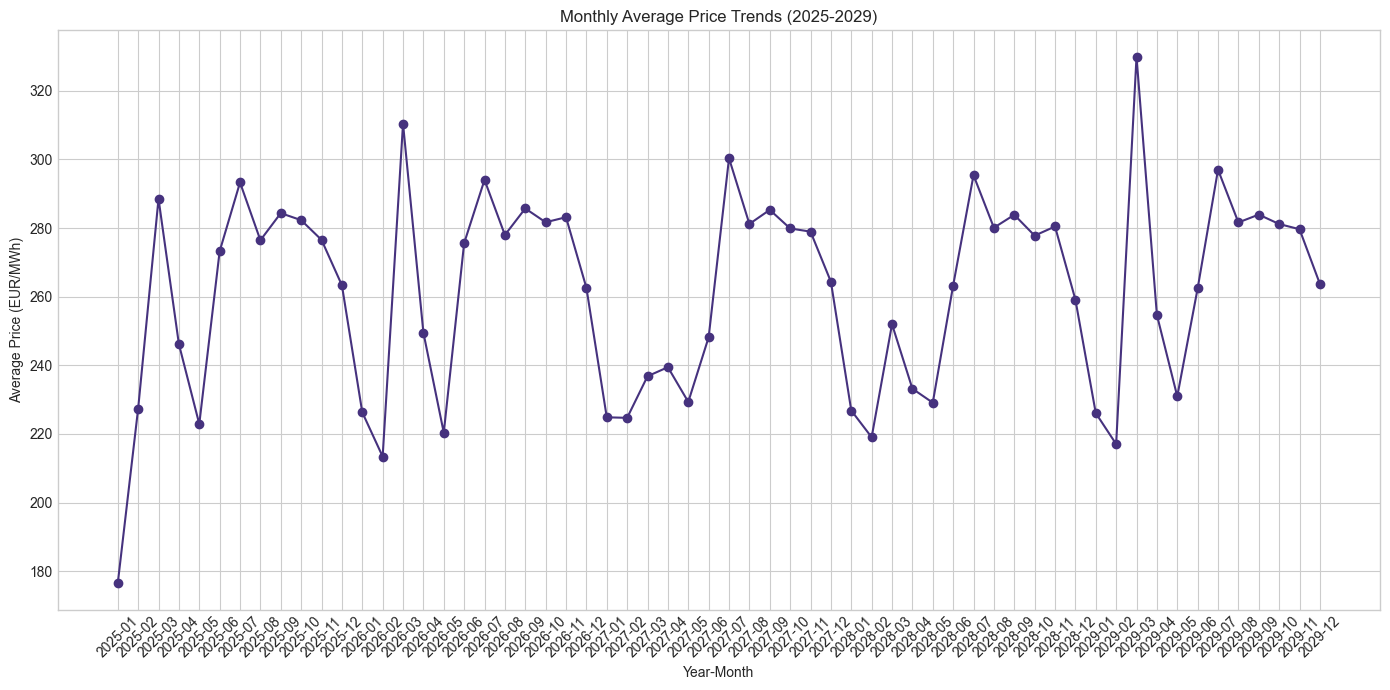

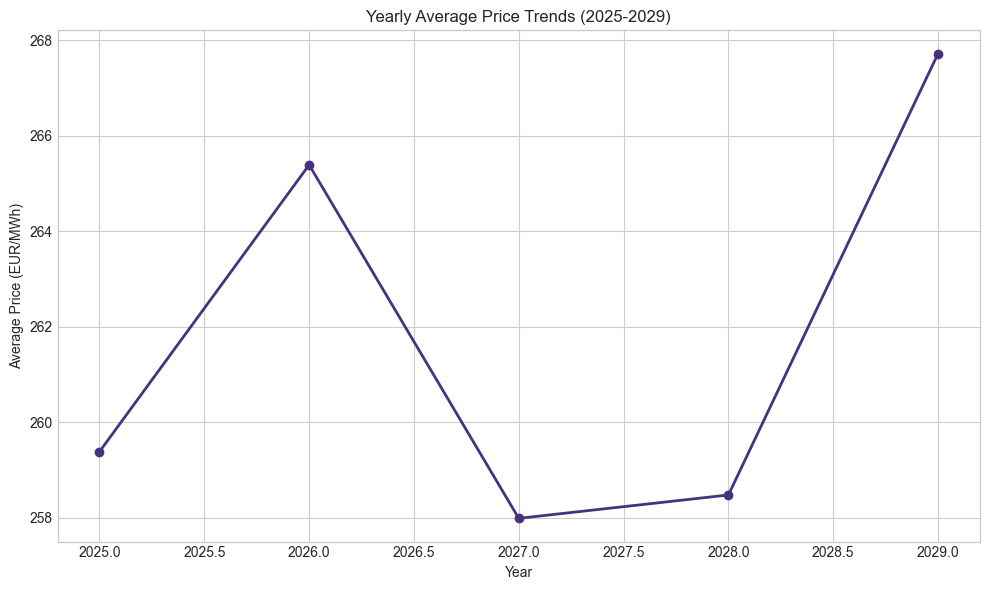

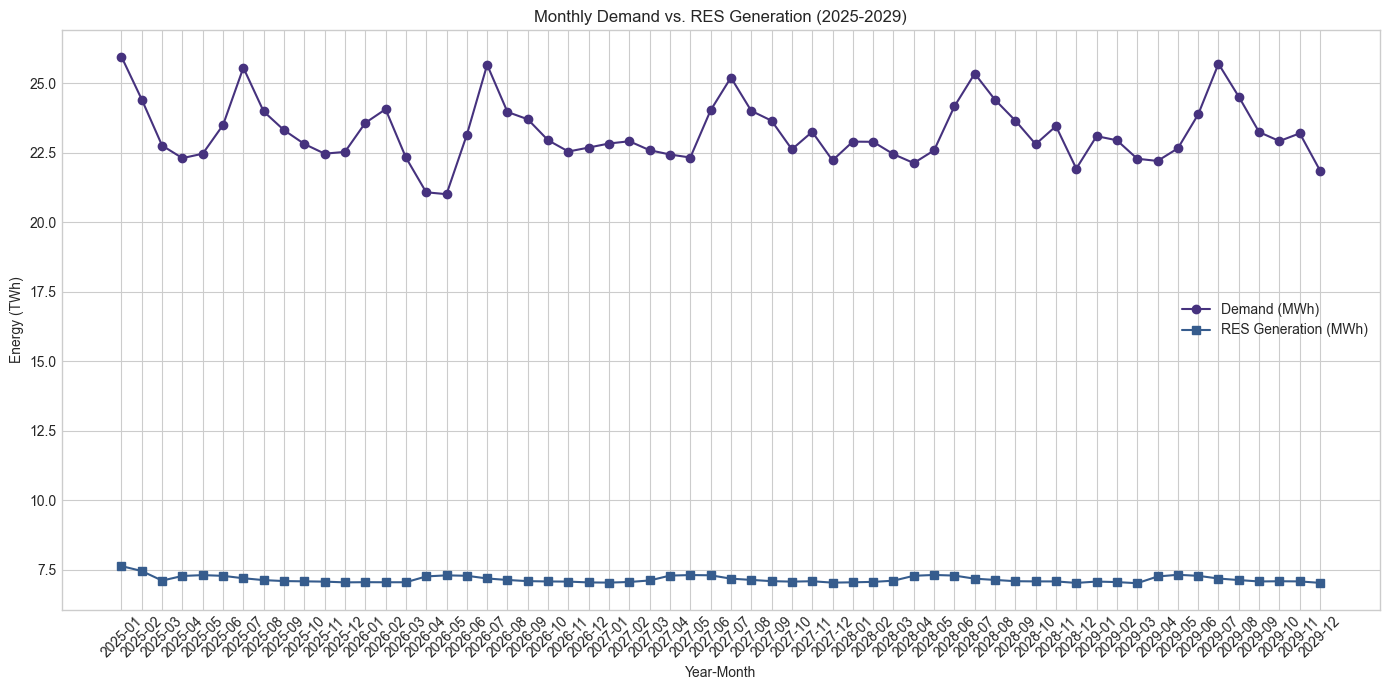

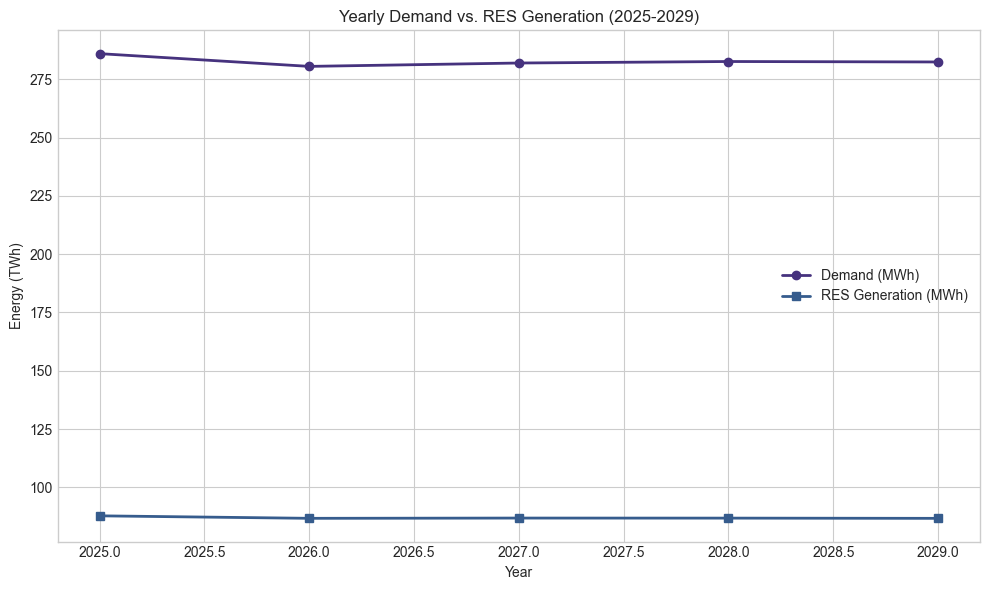

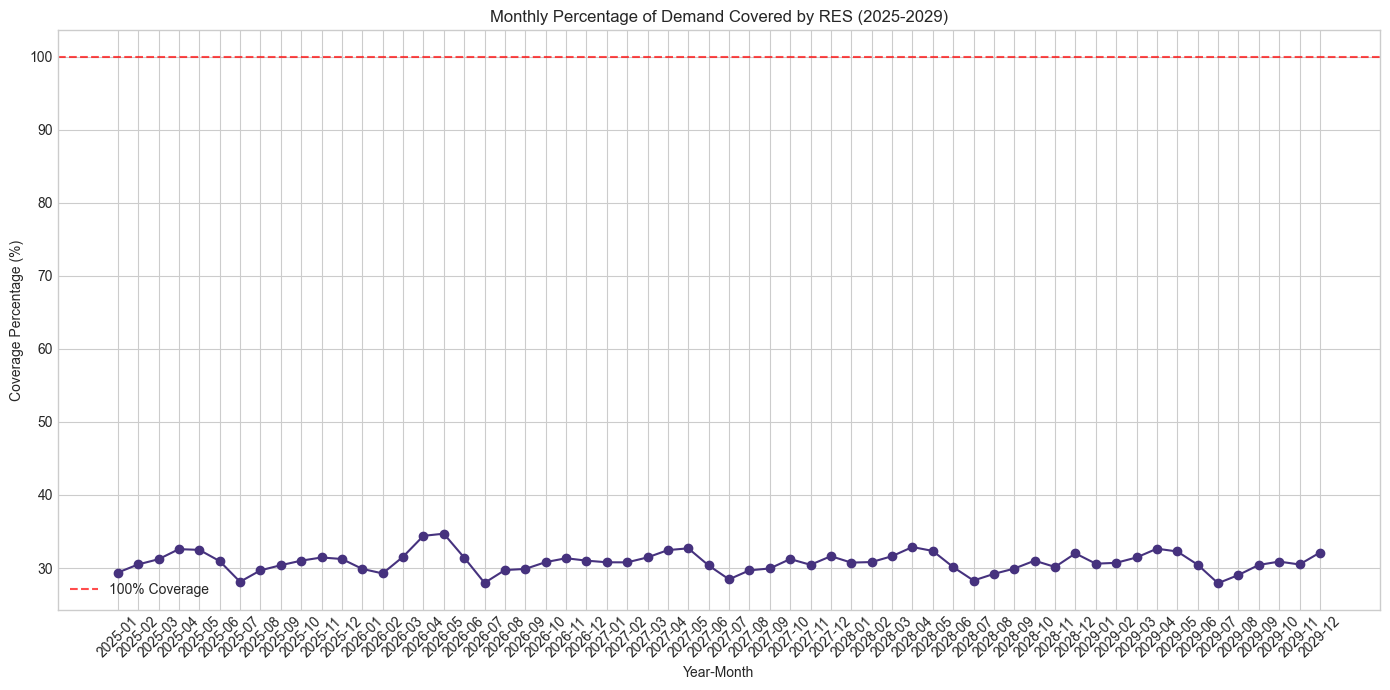

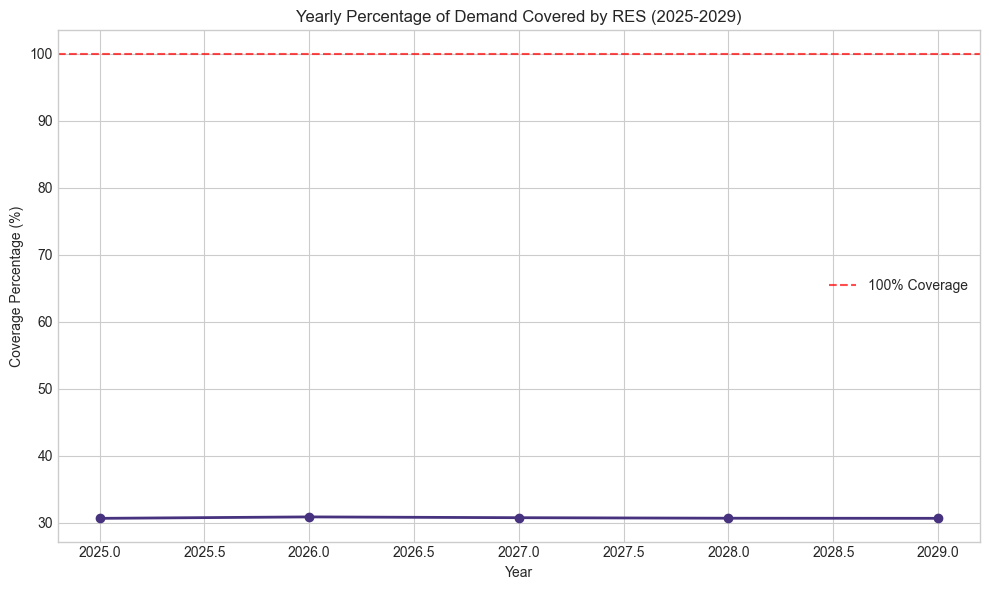

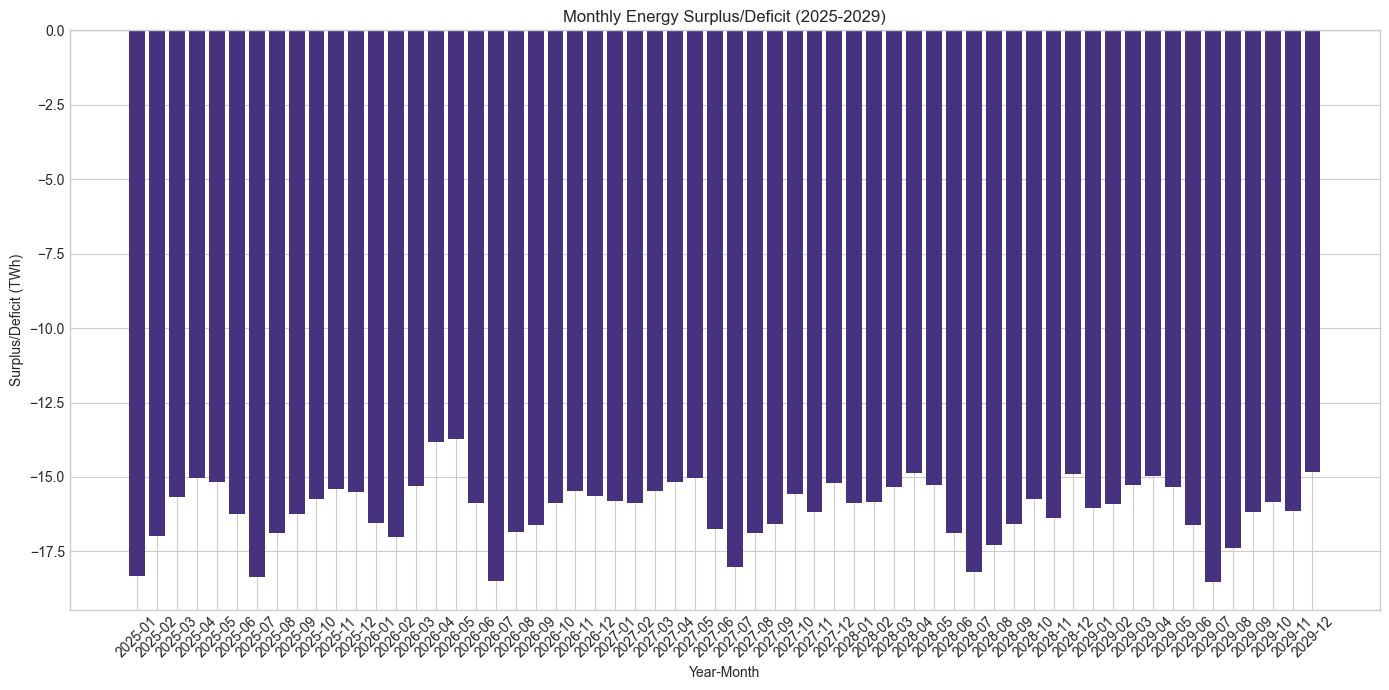

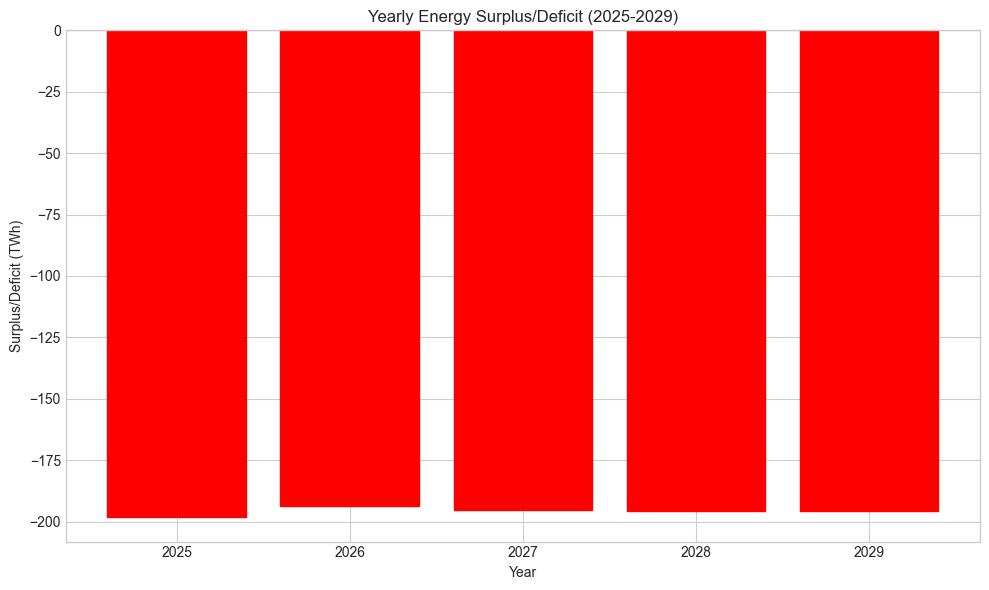

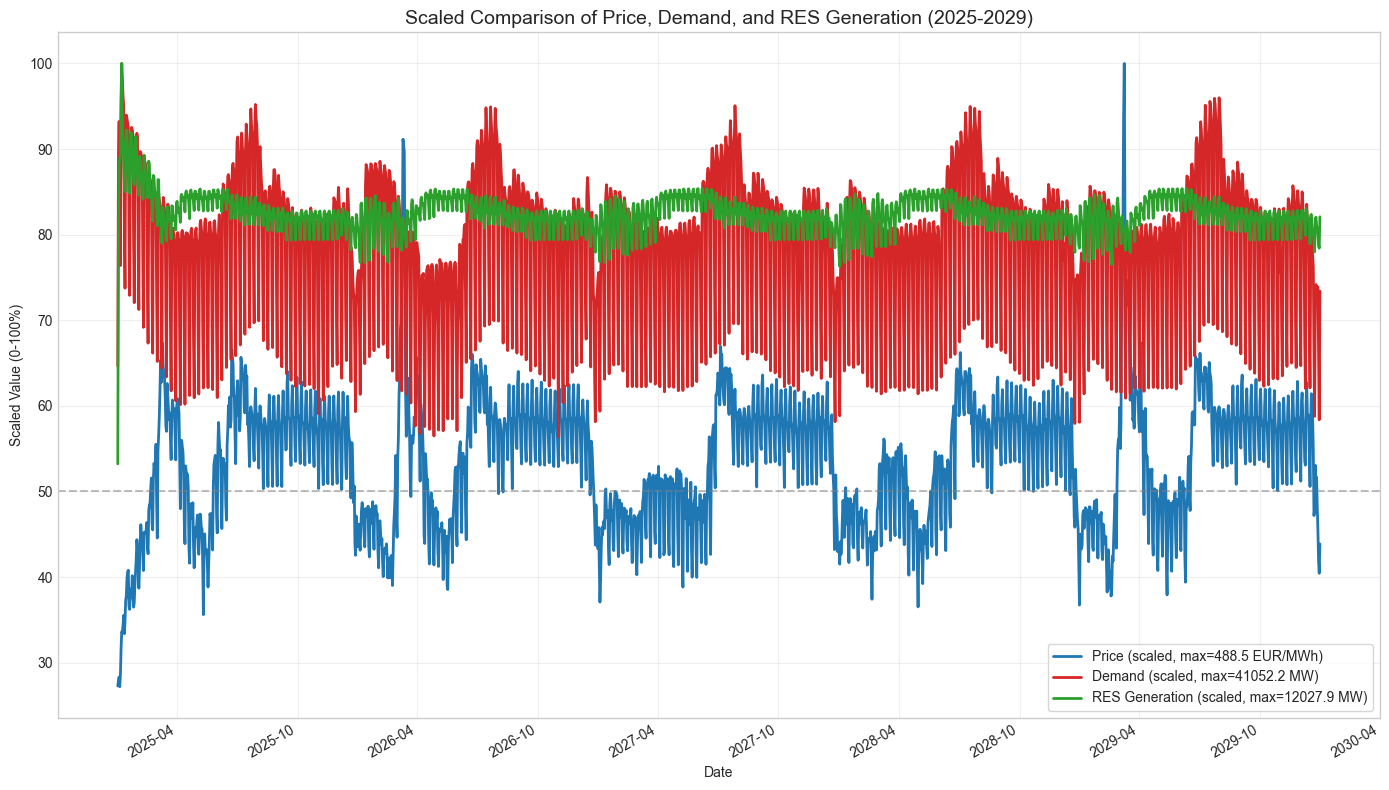

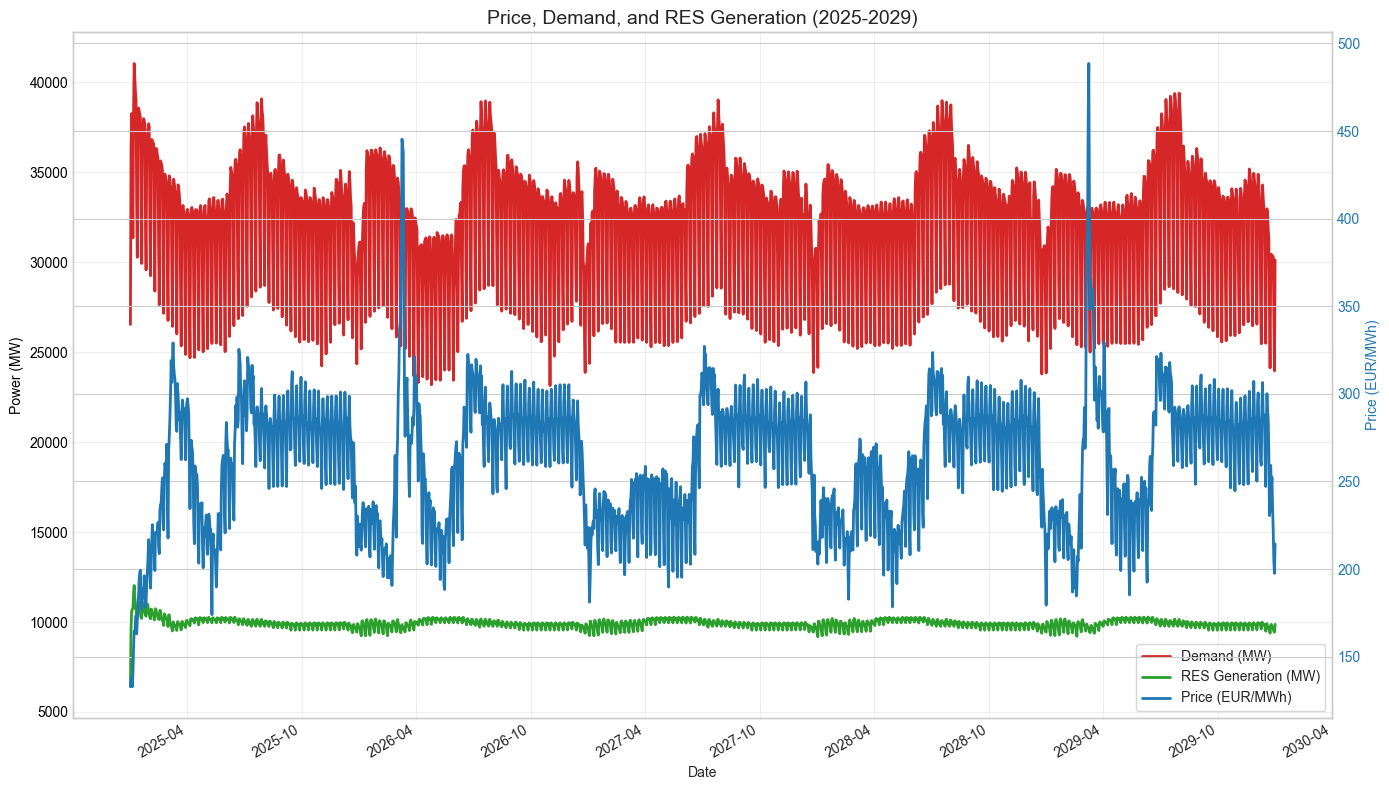

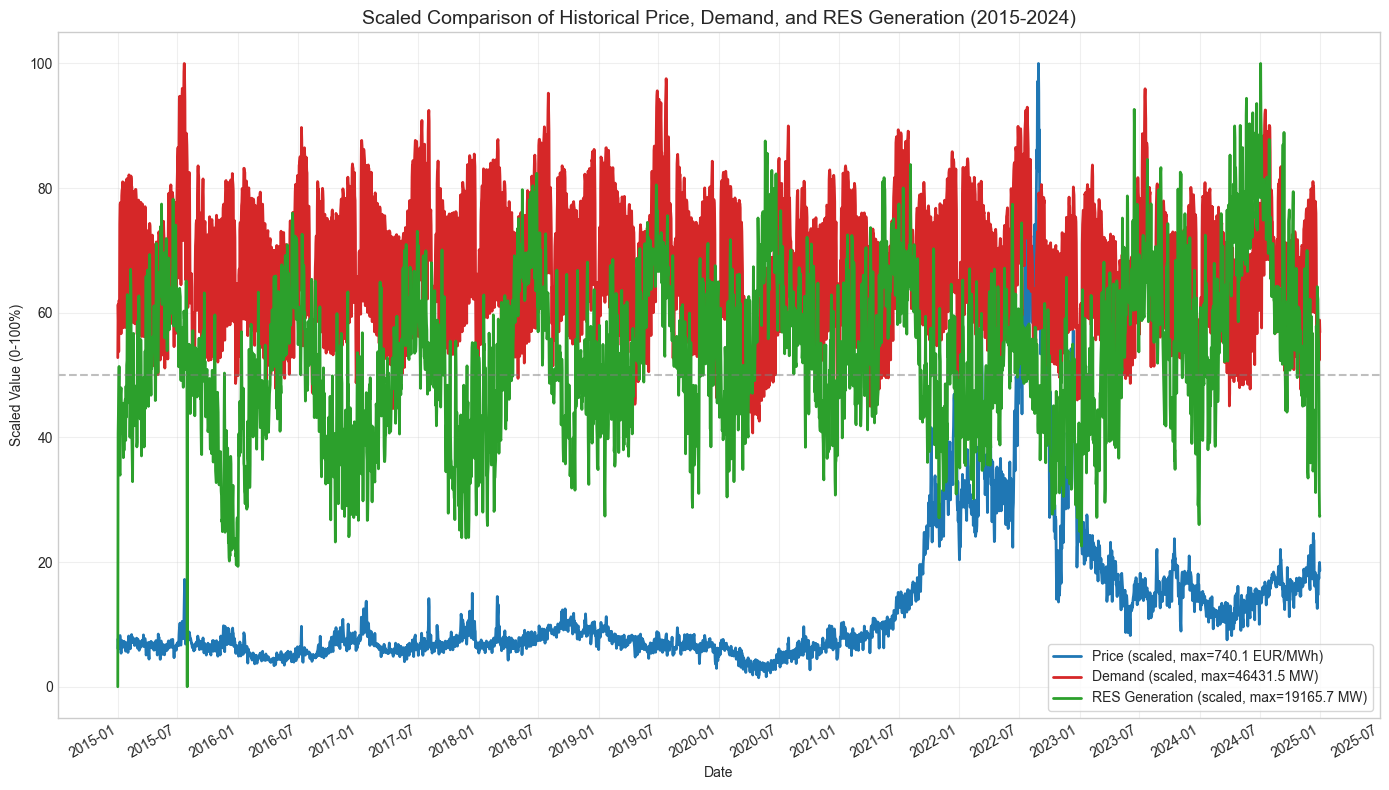

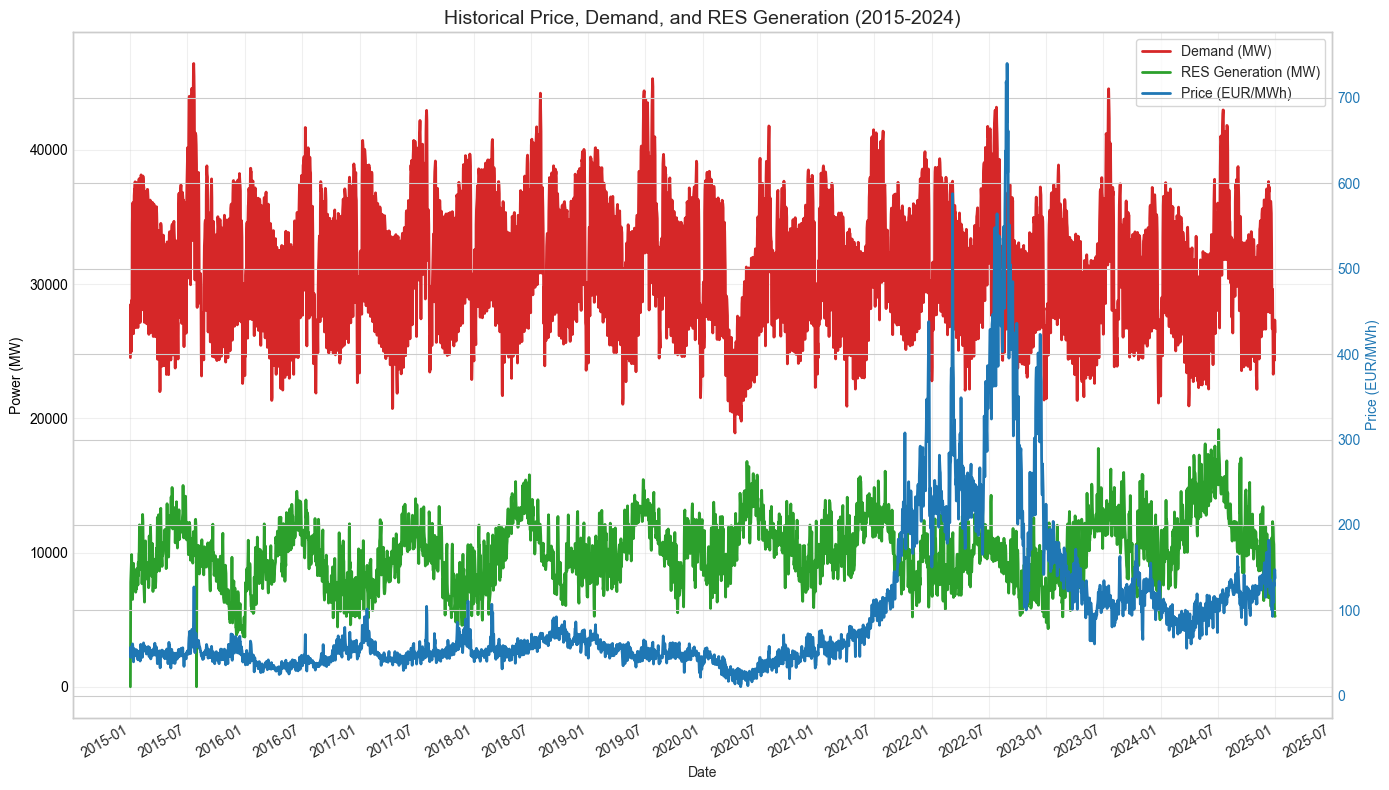

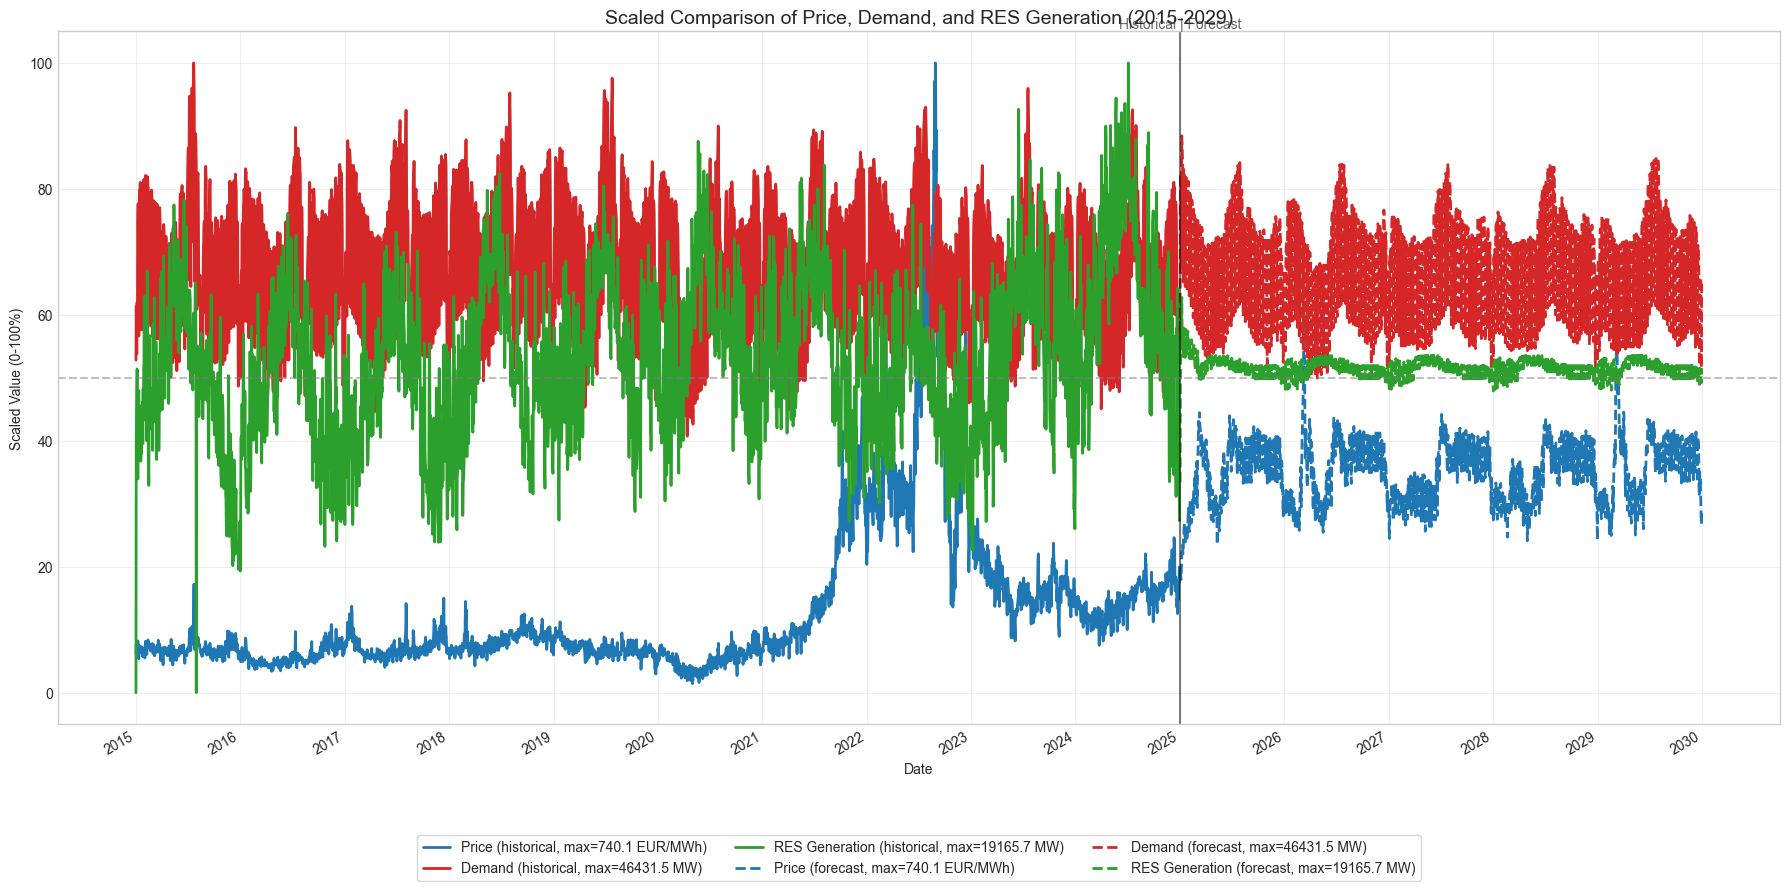

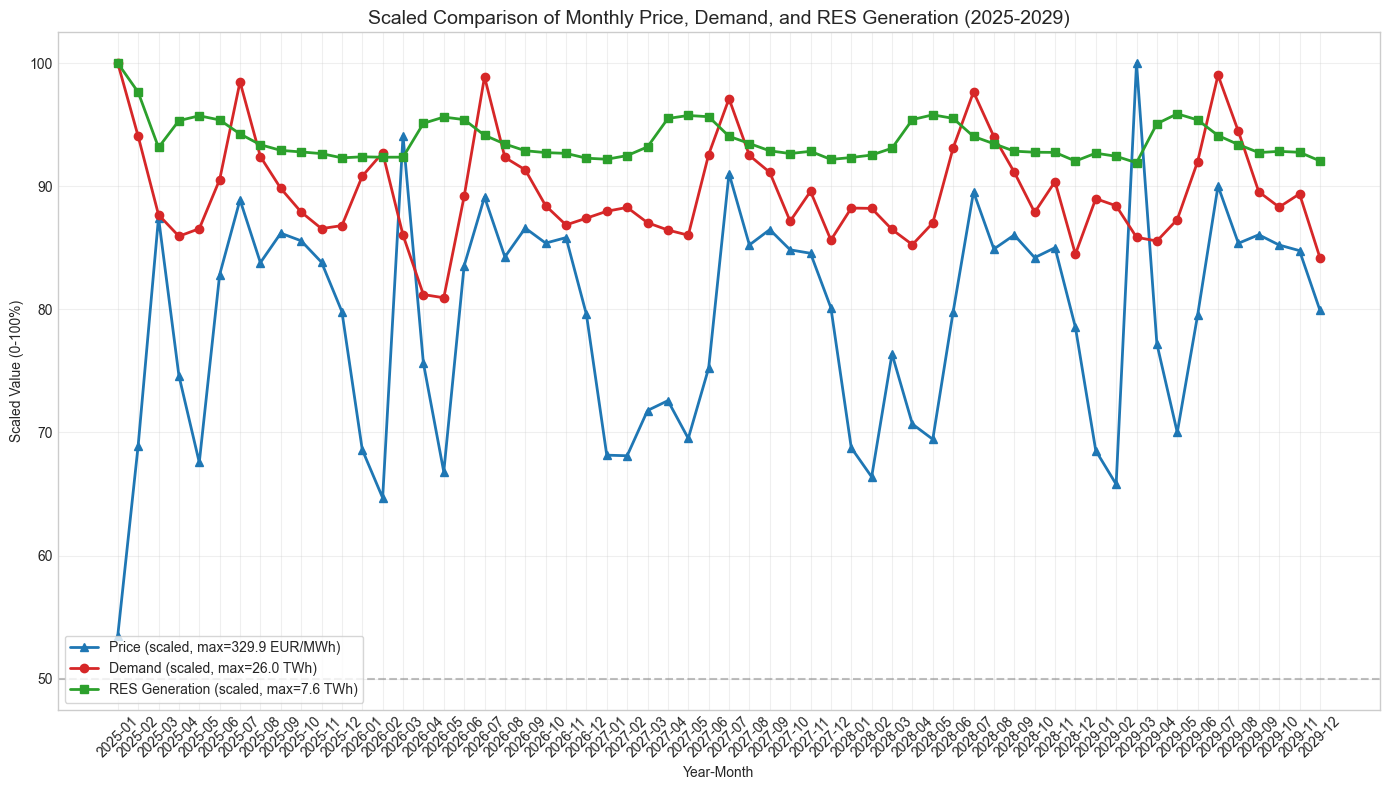

In [7]:
"""Main function to run the analysis."""
# Load data
price_df, demand_df, res_df = load_data()

# Preprocess data
merged_df = preprocess_data(price_df, demand_df, res_df)

# Calculate monthly aggregations
monthly_agg = calculate_monthly_aggregations(merged_df)

# Calculate yearly aggregations
yearly_agg = calculate_yearly_aggregations(merged_df)

# Create visualizations
create_visualizations(monthly_agg, yearly_agg)

# Save results to CSV files
save_results(monthly_agg, yearly_agg)

# Create combined dataset visualizations
plot_combined_dataset()

# Create historical dataset visualizations
plot_historical_dataset()

# Create monthly analysis visualizations
plot_monthly_analysis()

print("Analysis completed successfully!")